In [1]:
# Start to the project
%pip freeze

absl-py==2.2.2
asttokens==3.0.0
astunparse==1.6.3
branca==0.8.1
certifi==2025.4.26
charset-normalizer==3.4.2
comm==0.2.2
contourpy==1.3.2
cycler==0.12.1
debugpy==1.8.14
decorator==5.2.1
dotenv==0.9.9
executing==2.2.0
flatbuffers==25.2.10
folium==0.19.7
fonttools==4.58.0
gast==0.6.0
geographiclib==2.0
geopy==2.4.1
git-filter-repo==2.47.0
google-pasta==0.2.0
googlemaps==4.10.0
grpcio==1.71.0
h5py==3.13.0
idna==3.10
imbalanced-learn==0.13.0
ipykernel==6.29.5
ipython==9.2.0
ipython_pygments_lexers==1.1.1
jedi==0.19.2
Jinja2==3.1.6
joblib==1.5.0
jupyter_client==8.6.3
jupyter_core==5.7.2
keras==3.10.0
keras-tuner==1.4.7
kiwisolver==1.4.8
kt-legacy==1.0.5
libclang==18.1.1
Markdown==3.8
markdown-it-py==3.0.0
MarkupSafe==3.0.2
matplotlib==3.10.3
matplotlib-inline==0.1.7
mdurl==0.1.2
ml_dtypes==0.5.1
namex==0.0.9
nest-asyncio==1.6.0
numpy==2.1.3
opt_einsum==3.4.0
optree==0.15.0
packaging==25.0
pandas==2.2.3
parso==0.8.4
pexpect==4.9.0
pillow==11.2.1
platformdirs==4.3.8
polyline==2.0.2
prompt_too

In [2]:
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Import SMOTE for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE, BorderlineSMOTE
    SMOTE_AVAILABLE = True
    print("✅ SMOTE available for class imbalance handling")
except ImportError:
    SMOTE_AVAILABLE = False
    print("⚠️ SMOTE not available. Install with: pip install imbalanced-learn")

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, BatchNormalization, Attention, MultiHeadAttention, LayerNormalization
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

print("=" * 80)
print("INDIVIDUAL TIMELINE LOCATION PREDICTION SYSTEM")
print("=" * 80)
print("All required libraries loaded successfully!")
print("TensorFlow version:", tf.__version__)
print("Ready to process Google Timeline data...")
print("=" * 80)
print(f"SMOTE_AVAILABLE Status: {SMOTE_AVAILABLE}")


✅ SMOTE available for class imbalance handling


2025-11-03 17:25:04.468542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762187104.598424  890692 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762187104.637564  890692 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762187104.924206  890692 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762187104.924296  890692 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762187104.924299  890692 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INDIVIDUAL TIMELINE LOCATION PREDICTION SYSTEM
All required libraries loaded successfully!
TensorFlow version: 2.19.0
Ready to process Google Timeline data...
SMOTE_AVAILABLE Status: True


In [4]:
# 1: Google Timeline Data Processor

class GoogleTimelineDataProcessor:
    def __init__(self):
        self.raw_segments = []
        self.parsed_data = pd.DataFrame()
        self.visits_df = pd.DataFrame()
        self.activities_df = pd.DataFrame()
        self.paths_df = pd.DataFrame()
        print("\n📊 Stage 1: Google Timeline Parser Initialized")
        print("-" * 50)

    def parse_coordinate(self, coord_str):
        """Parse coordinate string to latitude, longitude tuple"""
        try:
            parts = coord_str.replace('°', '').split(', ')
            return float(parts[0]), float(parts[1])
        except:
            return None, None

    def _clean_data(self, visits_df, activities_df, fallback_threshold_m: float = 50.0):
        """Clean and standardize the extracted visits and activities dataframes."""
        if (visits_df is None or visits_df.empty) and (activities_df is None or activities_df.empty):
            raise ValueError("No timeline data available for cleaning.")

        visits_df = visits_df.copy() if visits_df is not None else pd.DataFrame()
        activities_df = activities_df.copy() if activities_df is not None else pd.DataFrame()

        def _haversine_m(lat1, lon1, lat2, lon2):
            if any(pd.isna(v) for v in [lat1, lon1, lat2, lon2]):
                return None
            R = 6371000.0
            lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
            c = 2 * np.arcsin(np.sqrt(a))
            return float(R * c)

        def _clean_coordinates(df, lat_col='latitude', lng_col='longitude'):
            if df.empty:
                return df
            df[lat_col] = pd.to_numeric(df[lat_col], errors='coerce')
            df[lng_col] = pd.to_numeric(df[lng_col], errors='coerce')
            df = df.dropna(subset=[lat_col, lng_col]).reset_index(drop=True)
            df = df[(df[lat_col] != 0) & (df[lng_col] != 0)].reset_index(drop=True)
            if df[lat_col].nunique() > 10 and df[lng_col].nunique() > 10:
                lat_bounds = df[lat_col].quantile([0.001, 0.999])
                lng_bounds = df[lng_col].quantile([0.001, 0.999])
                df = df[
                    df[lat_col].between(lat_bounds.iloc[0], lat_bounds.iloc[1]) &
                    df[lng_col].between(lng_bounds.iloc[0], lng_bounds.iloc[1])
                ].reset_index(drop=True)
            return df

        # --- Clean visits ---
        if not visits_df.empty:
            visits_df['timestamp'] = pd.to_datetime(visits_df['timestamp'], errors='coerce')
            visits_df = visits_df.dropna(subset=['timestamp']).reset_index(drop=True)
            visits_df = _clean_coordinates(visits_df)
            visits_df = visits_df.sort_values('timestamp').reset_index(drop=True)
            visits_df = visits_df.drop_duplicates(subset=['timestamp', 'latitude', 'longitude']).reset_index(drop=True)

        # --- Clean activities ---
        activity_corrections = 0
        if not activities_df.empty:
            activities_df['timestamp'] = pd.to_datetime(activities_df['timestamp'], errors='coerce')
            activities_df = activities_df.dropna(subset=['timestamp']).reset_index(drop=True)
            activities_df = _clean_coordinates(activities_df)
            # Ensure expected metadata columns exist
            for col in ['activity_end_source', 'activity_end_distance_from_start_m',
                        'parking_latitude', 'parking_longitude',
                        'next_visit_latitude', 'next_visit_longitude']:
                if col not in activities_df.columns:
                    activities_df[col] = np.nan

            activities_df = activities_df.sort_values('timestamp').reset_index(drop=True)
            activities_df = activities_df.drop_duplicates(
                subset=['timestamp', 'latitude', 'longitude', 'type']
            ).reset_index(drop=True)

            if 'segment_idx' in activities_df.columns:
                start_rows = (
                    activities_df[activities_df['type'] == 'activity_start']
                    .sort_values('timestamp')
                    .groupby('segment_idx')
                    .tail(1)
                    .set_index('segment_idx')
                )

                end_mask = activities_df['type'] == 'activity_end'
                for idx_end in activities_df[end_mask].index:
                    end_row = activities_df.loc[idx_end]
                    seg_id = end_row.get('segment_idx')
                    if pd.isna(seg_id) or seg_id not in start_rows.index:
                        continue

                    start_row = start_rows.loc[seg_id]
                    dist_from_start = _haversine_m(
                        start_row['latitude'], start_row['longitude'],
                        end_row['latitude'], end_row['longitude']
                    )
                    activities_df.at[idx_end, 'activity_end_distance_from_start_m'] = dist_from_start

                    if dist_from_start is not None and dist_from_start > fallback_threshold_m:
                        continue

                    candidates = []
                    if not pd.isna(end_row.get('parking_latitude')) and not pd.isna(end_row.get('parking_longitude')):
                        candidates.append(('parking_location', end_row['parking_latitude'], end_row['parking_longitude']))
                    if not pd.isna(end_row.get('next_visit_latitude')) and not pd.isna(end_row.get('next_visit_longitude')):
                        candidates.append(('next_visit', end_row['next_visit_latitude'], end_row['next_visit_longitude']))

                    for source, cand_lat, cand_lon in candidates:
                        cand_dist = _haversine_m(start_row['latitude'], start_row['longitude'], cand_lat, cand_lon)
                        if cand_dist is None:
                            continue
                        if cand_dist > fallback_threshold_m:
                            activities_df.at[idx_end, 'latitude'] = cand_lat
                            activities_df.at[idx_end, 'longitude'] = cand_lon
                            activities_df.at[idx_end, 'activity_end_source'] = source
                            activities_df.at[idx_end, 'activity_end_distance_from_start_m'] = cand_dist
                            activity_corrections += 1
                            break

        # Combine for downstream steps
        combined_df = pd.concat([activities_df, visits_df], ignore_index=True, sort=False)
        combined_df = combined_df.sort_values('timestamp').reset_index(drop=True)

        print(f"✓ Cleaned timeline data: visits={len(visits_df)}, activities={len(activities_df)}")
        if activity_corrections:
            print(f"   • Activity end corrections applied: {activity_corrections}")

        self.visits_df = visits_df
        self.activities_df = activities_df
        self.parsed_data = combined_df
        return visits_df, activities_df, combined_df

    def load_and_preprocess_data(self, json_files):    
        """Load and combine multiple Google Timeline JSON files"""
        print(f"🔄 Loading {len(json_files)} JSON files...")
        
        all_segments = []
        successful_loads = 0
        
        for i, file_path in enumerate(json_files, 1):
            try:
                print(f"   📁 Loading file {i}/{len(json_files)}: {file_path}")
                
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    segments = data.get('semanticSegments', [])
                    all_segments.extend(segments)
                    successful_loads += 1
                    
                print(f"   ✅ Successfully loaded {len(segments)} segments")
                
            except FileNotFoundError:
                print(f"   ❌ File not found: {file_path}")
            except json.JSONDecodeError as e:
                print(f"   ❌ JSON parsing error in {file_path}: {e}")
            except Exception as e:
                print(f"   ❌ Error loading {file_path}: {e}")
        
        self.raw_segments = all_segments
        
        print(f"\n📈 LOADING SUMMARY:")
        print(f"   • Files processed: {successful_loads}/{len(json_files)}")
        print(f"   • Total segments loaded: {len(all_segments)}")
        print(f"   • Memory usage: {len(str(all_segments)) / 1024:.1f} KB")
        
        return all_segments
    
    def _extract_timeline_data(self, data, include_timeline_path: bool = False):
        """
        Extract timeline data into separate visit and activity records (plus optional paths).
        Returns (visits_df, activities_df, paths_df).
        """
        def _safe_to_dt(x):
            return pd.to_datetime(x, errors='coerce')
        
        def _parse_latlng(latlng_str):
            try:
                lat_str, lon_str = latlng_str.split(',')
                return float(lat_str.replace('°', '').strip()), float(lon_str.replace('°', '').strip())
            except Exception:
                return None, None
        
        def _distance_m(lat1, lon1, lat2, lon2):
            if any(pd.isna(v) for v in [lat1, lon1, lat2, lon2]):
                return None
            R = 6371000.0
            lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
            dlat = lat2 - lat1
            dlon = dlon = lon2 - lon1
            a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
            c = 2 * np.arcsin(np.sqrt(a))
            return float(R * c)
        
        # Determine entries list
        if isinstance(data, list):
            entries = data
        elif isinstance(data, dict) and 'semanticSegments' in data:
            entries = data['semanticSegments']
        else:
            entries = [data]
        
        visit_rows = []
        activity_rows = []
        path_rows = []
        stats = {"visits": 0, "activity_points": 0, "paths": 0, "errors": 0}
        
        for idx, seg in enumerate(entries):
            if idx % 250 == 0 and idx > 0:
                print(f"   🔄 Processed {idx}/{len(entries)} segments...")
            try:
                start_time = _safe_to_dt(seg.get('startTime'))
                end_time = _safe_to_dt(seg.get('endTime'))

                # VISIT
                if 'visit' in seg:
                    visit = seg['visit']
                    top = visit.get('topCandidate', {})
                    latlng = top.get('placeLocation', {}).get('latLng', '')
                    lat, lon = _parse_latlng(latlng) if latlng else (None, None)
                    if lat is not None and lon is not None:
                        duration_minutes = None
                        if pd.notna(start_time) and pd.notna(end_time):
                            duration_minutes = (end_time - start_time).total_seconds() / 60.0
                        visit_rows.append({
                            'timestamp': start_time,
                            'latitude': lat,
                            'longitude': lon,
                            'type': 'visit',
                            'semantic_type': top.get('semanticType', 'UNKNOWN'),
                            'place_id': top.get('placeId', ''),
                            'probability': visit.get('probability', 0),
                            'duration_minutes': duration_minutes,
                            'segment_start': start_time,
                            'segment_end': end_time,
                            'segment_idx': idx
                        })
                        stats['visits'] += 1

                # ACTIVITY start/end
                if 'activity' in seg:
                    act = seg['activity']
                    act_type = act.get('topCandidate', {}).get('type', 'UNKNOWN')
                    act_prob = act.get('topCandidate', {}).get('probability', 0)
                    dist_m = act.get('distanceMeters', 0)

                    start_lat = start_lon = None
                    start_latlng = act.get('start', {}).get('latLng', '')
                    if start_latlng:
                        start_lat, start_lon = _parse_latlng(start_latlng)
                        if start_lat is not None and start_lon is not None:
                            activity_rows.append({
                                'timestamp': start_time,
                                'latitude': start_lat,
                                'longitude': start_lon,
                                'type': 'activity_start',
                                'activity_type': act_type,
                                'activity_probability': act_prob,
                                'distance_meters': dist_m,
                                'segment_start': start_time,
                                'segment_end': end_time,
                                'segment_idx': idx
                            })
                            stats['activity_points'] += 1

                    end_lat = end_lon = None
                    end_latlng = act.get('end', {}).get('latLng', '')
                    if end_latlng:
                        end_lat, end_lon = _parse_latlng(end_latlng)

                    parking_lat = parking_lon = None
                    parking = act.get('parking', {}) if isinstance(act, dict) else {}
                    if isinstance(parking, dict):
                        parking_latlng = parking.get('location', {}).get('latLng') or parking.get('latLng')
                        if parking_latlng:
                            parking_lat, parking_lon = _parse_latlng(parking_latlng)

                    next_visit_lat = next_visit_lon = None
                    if idx + 1 < len(entries):
                        next_seg = entries[idx + 1]
                        if isinstance(next_seg, dict) and 'visit' in next_seg:
                            next_visit = next_seg['visit']
                            visit_latlng = next_visit.get('topCandidate', {}).get('placeLocation', {}).get('latLng', '')
                            if visit_latlng:
                                next_visit_lat, next_visit_lon = _parse_latlng(visit_latlng)

                    if end_lat is not None and end_lon is not None:
                        dist_from_start = _distance_m(start_lat, start_lon, end_lat, end_lon)
                        activity_rows.append({
                            'timestamp': end_time,
                            'latitude': end_lat,
                            'longitude': end_lon,
                            'type': 'activity_end',
                            'activity_type': act_type,
                            'activity_probability': act_prob,
                            'distance_meters': dist_m,
                            'activity_end_source': 'activity_end',
                            'activity_end_distance_from_start_m': dist_from_start,
                            'parking_latitude': parking_lat,
                            'parking_longitude': parking_lon,
                            'next_visit_latitude': next_visit_lat,
                            'next_visit_longitude': next_visit_lon,
                            'segment_start': start_time,
                            'segment_end': end_time,
                            'segment_idx': idx
                        })
                        stats['activity_points'] += 1

                # Optional TIMELINE PATH summarization
                if include_timeline_path and 'timelinePath' in seg:
                    path = seg['timelinePath']
                    if isinstance(path, list) and len(path) >= 2:
                        coords = []
                        for p in path:
                            try:
                                plat, plon = _parse_latlng(p.get('point', ''))
                                ptime = _safe_to_dt(p.get('time'))
                                if plat is not None and plon is not None and pd.notna(ptime):
                                    coords.append((plat, plon, ptime))
                            except Exception:
                                continue
                        if len(coords) >= 2:
                            total_dist_m = 0.0
                            for i in range(1, len(coords)):
                                seg_dist = _distance_m(coords[i-1][0], coords[i-1][1], coords[i][0], coords[i][1])
                                if seg_dist is not None:
                                    total_dist_m += seg_dist
                            duration_minutes = (coords[-1][2] - coords[0][2]).total_seconds() / 60.0
                            avg_speed_m_s = (total_dist_m / (duration_minutes * 60.0)) if duration_minutes > 0 else 0.0
                            path_rows.append({
                                'timestamp': start_time,
                                'latitude': coords[0][0],
                                'longitude': coords[0][1],
                                'type': 'path',
                                'start_latitude': coords[0][0],
                                'start_longitude': coords[0][1],
                                'end_latitude': coords[-1][0],
                                'end_longitude': coords[-1][1],
                                'total_distance_m': total_dist_m,
                                'duration_minutes': duration_minutes,
                                'avg_speed_m_s': avg_speed_m_s,
                                'segment_start': start_time,
                                'segment_end': end_time,
                                'segment_idx': idx
                            })
                            stats['paths'] += 1

            except Exception as e:
                stats['errors'] += 1
                if stats['errors'] <= 5:
                    print(f"Error parsing segment #{idx}: {str(e)[:120]}")

        visits_df = pd.DataFrame(visit_rows)
        activities_df = pd.DataFrame(activity_rows)
        paths_df = pd.DataFrame(path_rows)

        combined_df = pd.concat([activities_df, visits_df, paths_df], ignore_index=True, sort=False)
        if not combined_df.empty and 'timestamp' in combined_df.columns:
            combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], errors='coerce')
            combined_df = combined_df.sort_values('timestamp').reset_index(drop=True)

        self.visits_df = visits_df
        self.activities_df = activities_df
        self.paths_df = paths_df
        self.parsed_data = combined_df

        if not combined_df.empty:
            time_range = combined_df['timestamp'].max() - combined_df['timestamp'].min()
            print(f"\n📈 EXTRACTION SUMMARY:")
            print(f"   • Visits: {stats['visits']}")
            print(f"   • Activity points: {stats['activity_points']}")
            if include_timeline_path:
                print(f"   • Path summaries: {stats['paths']}")
            print(f"   • Errors: {stats['errors']}")
            print(f"   • Date range: {time_range.days} days")
            print(f"   • First record: {combined_df['timestamp'].min()}")
            print(f"   • Last record: {combined_df['timestamp'].max()}")

            type_counts = combined_df['type'].value_counts()
            print(f"\n📊 DATA TYPES BREAKDOWN:")
            for data_type, count in type_counts.items():
                percentage = (count / len(combined_df)) * 100
                print(f"   • {data_type}: {count} ({percentage:.1f}%)")

        return visits_df, activities_df, paths_df

In [5]:
# Step 1: Initialize the parser
timeline_parser = GoogleTimelineDataProcessor()

# Step 2: Find and load timeline files with some additional cleanup and error handling
def find_timeline_files(base_path="split_timelines", target_years=[2024, 2025]):
    """
    Find all Google Maps timeline JSON files in the specified directory.
    
    Args:
        directory (str): Directory to search for JSON files
        
    Returns:
        list: List of JSON file paths
    """
    print(f"Finding timeline files for years {target_years}...")
    timeline_files = []
    
    if not os.path.exists(base_path):
        print(f"✗ Error: Directory '{base_path}' not found!")
        return timeline_files
    
    # Add all months for each target year
    for year in target_years:
        if year == 2025:
            # For 2025, only include months 1-7 (up to current month)
            month_range = range(1, 8)  # January to July
        else:
            # For other years, include all 12 months
            month_range = range(1, 13)  # January to December
        
        for month in month_range:
            filename = f"timeline_{year}-{month:02d}.json"
            file_path = os.path.join(base_path, filename)
            
            if os.path.exists(file_path):
                timeline_files.append(file_path)
                print(f"✓ Found timeline file: {file_path}")
            else:
                print(f"✗ Warning: File not found for {year}-{month:02d}, skipping.")
    
    if not timeline_files:
        print(f"✗ No timeline files found for the specified years in the '{base_path}' directory.")
        print(f"Please check that your timeline files follow the naming pattern: timeline_YYYY-MM.json")
        print(f"Example: timeline_2024-01.json, timeline_2024-02.json, etc.")
    else:
        print(f"\n📊 Total files found: {len(timeline_files)}")
        
        # Display summary by year
        year_counts = {}
        for file_path in timeline_files:
            filename = os.path.basename(file_path)
            year = filename.split('-')[0].split('_')[1]  # Extract year from timeline_YYYY-MM.json
            year_counts[year] = year_counts.get(year, 0) + 1
        
        for year, count in sorted(year_counts.items()):
            print(f"   {year}: {count} months")
    
    return timeline_files

# Find timeline files for 2024 and 2025
json_files = find_timeline_files(base_path="split_timelines", target_years=[2024, 2025])

# Toggles / thresholds related to timeline extraction
INCLUDE_TIMELINE_PATH = False
FALLBACK_THRESHOLD_M = 50.0  # Distance threshold used when correcting activity end locations

# Load, extract, and clean the timeline data
visits_df = activities_df = paths_df = timeline_df = df = None
print(f"\n📂 Loading and preprocessing {len(json_files)} timeline files...")
try:
    timeline_parser.load_and_preprocess_data(json_files)

    visits_df, activities_df, paths_df = timeline_parser._extract_timeline_data(
        timeline_parser.raw_segments,
        include_timeline_path=INCLUDE_TIMELINE_PATH
    )

    visits_df, activities_df, timeline_df = timeline_parser._clean_data(
        visits_df,
        activities_df,
        fallback_threshold_m=FALLBACK_THRESHOLD_M
    )

    # Maintain compatibility with downstream cells that expect `df`
    df = timeline_df.copy()

    # Ensure the cached parser attributes are aligned with the latest dataframes
    paths_df = timeline_parser.paths_df
    timeline_df = timeline_parser.parsed_data

    print("✅ Successfully loaded timeline data!")
    print(f"   • Visits: {len(visits_df):,}")
    print(f"   • Activity points: {len(activities_df):,}")
    if INCLUDE_TIMELINE_PATH and isinstance(paths_df, pd.DataFrame) and not paths_df.empty:
        print(f"   • Path summaries: {len(paths_df):,}")
    print(f"   • Combined timeline records: {len(timeline_df):,}")
except Exception as e:
    print(f"❌ Error loading timeline data: {e}")
    print("\nTroubleshooting tips:")
    print("1. Check that your timeline files are in the 'split_timelines' folder")
    print("2. Verify the file naming pattern: timeline_YYYY-MM.json")
    print("3. Ensure the JSON files contain valid timeline data")
    visits_df = activities_df = paths_df = timeline_df = df = None




📊 Stage 1: Google Timeline Parser Initialized
--------------------------------------------------
Finding timeline files for years [2024, 2025]...
✓ Found timeline file: split_timelines/timeline_2024-01.json
✓ Found timeline file: split_timelines/timeline_2024-02.json
✓ Found timeline file: split_timelines/timeline_2024-03.json
✓ Found timeline file: split_timelines/timeline_2024-04.json
✓ Found timeline file: split_timelines/timeline_2024-05.json
✓ Found timeline file: split_timelines/timeline_2024-06.json
✓ Found timeline file: split_timelines/timeline_2024-07.json
✓ Found timeline file: split_timelines/timeline_2024-08.json
✓ Found timeline file: split_timelines/timeline_2024-09.json
✓ Found timeline file: split_timelines/timeline_2024-10.json
✓ Found timeline file: split_timelines/timeline_2024-11.json
✓ Found timeline file: split_timelines/timeline_2024-12.json
✓ Found timeline file: split_timelines/timeline_2025-01.json
✓ Found timeline file: split_timelines/timeline_2025-02.json


🎯 Stage 2: Location Clusterer Initialized
--------------------------------------------------
🔄 Creating location clusters using DBSCAN on visits only...
   Parameters: eps=0.001, min_samples=11
   🔄 Running DBSCAN clustering...
   📊 DBSCAN Results:
      • Visits processed: 2,073
      • Noise visits: 187
      • Visits in clusters: 1,886

📈 CLUSTER ANALYSIS RESULTS:
   • Visits clustered: 1,886
   • Noise visits: 187
   • Valid clusters: 20
   • Average visits per cluster: 94.3
   • Median cluster radius: 0.066 km
   • Most frequent record types (clustered rows): {'visit': 1886}

🏆 TOP 5 MOST VISITED LOCATIONS:
   1. Cluster 6: 425 visits
      📍 (9.0414, 7.4057)
      📊 Radius: 0.215 km, Unique days: 302, Visits/day: 1.41
   2. Cluster 4: 337 visits
      📍 (9.0436, 7.4096)
      📊 Radius: 0.098 km, Unique days: 176, Visits/day: 1.91
   3. Cluster 13: 329 visits
      📍 (8.9548, 7.3581)
      📊 Radius: 0.000 km, Unique days: 319, Visits/day: 1.03
   4. Cluster 1: 175 visits
      📍 

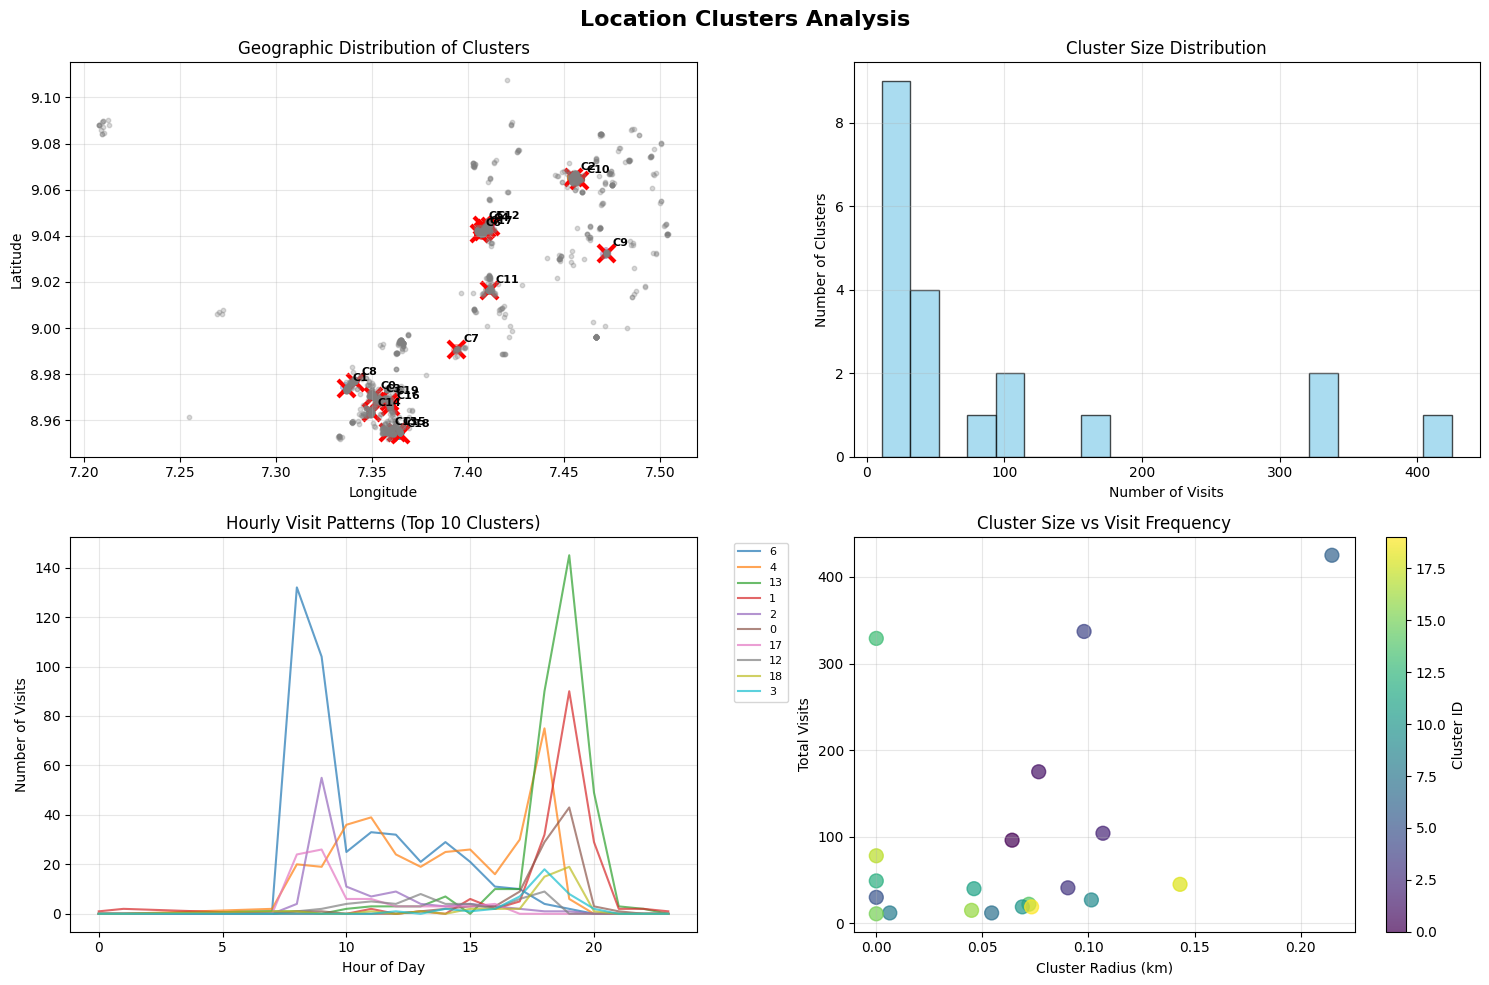

   ✅ Visualization complete!


In [6]:
# Step 3: Create location clusters with detailed analysis

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate haversine distance between two points"""
    R = 6371  # Earth's radius in kilometers

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c

    return distance


def create_location_clusters(
    visits_df,
    timeline_df=None,
    eps=0.001,
    min_samples=3,
    method="dbscan",
    assign_clusters_to_timeline=True,
):
    """Cluster visit locations and (optionally) propagate IDs to the combined timeline."""

    print(f"🔄 Creating location clusters using {method.upper()} on visits only...")
    print(f"   Parameters: eps={eps}, min_samples={min_samples}")

    if visits_df is None or visits_df.empty:
        print("❌ No visits available for clustering.")
        timeline_copy = timeline_df.copy() if timeline_df is not None else pd.DataFrame()
        if timeline_copy is not None and "cluster_id" not in timeline_copy.columns:
            timeline_copy["cluster_id"] = pd.Series(dtype="Int64")
        return timeline_copy, visits_df if visits_df is not None else pd.DataFrame(), [], None

    required_cols = {"latitude", "longitude", "timestamp"}
    missing_cols = required_cols - set(visits_df.columns)
    if missing_cols:
        raise ValueError(f"visits_df is missing required columns: {missing_cols}")

    visits = visits_df.copy()
    visits = visits.dropna(subset=["latitude", "longitude", "timestamp"]).reset_index(drop=True)
    visits = visits.sort_values("timestamp").reset_index(drop=True)

    coords = visits[["latitude", "longitude"]].to_numpy()

    if method == "dbscan":
        print("   🔄 Running DBSCAN clustering...")
        cluster_model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = cluster_model.fit_predict(coords)
        n_noise = int((labels == -1).sum())
        print("   📊 DBSCAN Results:")
        print(f"      • Visits processed: {len(coords):,}")
        print(f"      • Noise visits: {n_noise:,}")
        print(f"      • Visits in clusters: {len(coords) - n_noise:,}")
    else:
        n_clusters = max(1, min(50, max(5, len(visits) // 20)))
        print(f"   🔄 Running K-Means clustering with {n_clusters} clusters...")
        cluster_model = KMeans(n_clusters=n_clusters, random_state=42)
        labels = cluster_model.fit_predict(coords)
        n_noise = 0
        print("   📊 K-Means Results:")
        print(f"      • Visits processed: {len(coords):,}")
        print(f"      • Clustered visits: {len(coords):,}")

    visits["cluster_id"] = pd.Series(labels, dtype="Int64")
    if method == "dbscan" and n_noise:
        visits.loc[visits["cluster_id"] == -1, "cluster_id"] = pd.NA

    valid_visits = visits.dropna(subset=["cluster_id"])
    if valid_visits.empty:
        print("⚠️ All visits were treated as noise; returning without clusters.")
        timeline_copy = timeline_df.copy() if timeline_df is not None else pd.DataFrame()
        if timeline_copy is not None:
            timeline_copy["cluster_id"] = pd.Series(dtype="Int64")
        return timeline_copy, visits, [], cluster_model

    cluster_summary = (
        valid_visits.groupby("cluster_id").agg(
            center_lat=("latitude", "mean"),
            lat_std=("latitude", "std"),
            lat_min=("latitude", "min"),
            lat_max=("latitude", "max"),
            center_lng=("longitude", "mean"),
            lng_std=("longitude", "std"),
            lng_min=("longitude", "min"),
            lng_max=("longitude", "max"),
            visit_count=("timestamp", "count"),
            first_visit=("timestamp", "min"),
            last_visit=("timestamp", "max"),
        )
    ).reset_index()
    cluster_summary["cluster_id"] = cluster_summary["cluster_id"].astype(int)
    cluster_summary["dominant_type"] = "visit"

    unique_days = (
        valid_visits.groupby("cluster_id")["timestamp"]
        .apply(lambda s: s.dt.floor("D").nunique())
        .reset_index(name="unique_days")
    )
    cluster_summary = cluster_summary.merge(unique_days, on="cluster_id", how="left")
    cluster_summary["unique_days"] = cluster_summary["unique_days"].fillna(1).astype(int)

    timespan_days = (
        (cluster_summary["last_visit"] - cluster_summary["first_visit"]).dt.total_seconds() / 86400.0
    )
    cluster_summary["time_span_days"] = timespan_days.clip(lower=0)
    cluster_summary["visits_per_day"] = (
        cluster_summary["visit_count"] / cluster_summary["unique_days"].replace(0, 1)
    )

    centers = cluster_summary.set_index("cluster_id")[["center_lat", "center_lng"]]
    visits_with_centers = valid_visits.merge(
        centers,
        left_on="cluster_id",
        right_index=True,
        suffixes=("", "_center"),
    )
    visits_with_centers["distance_km"] = visits_with_centers.apply(
        lambda row: haversine_distance(
            row["center_lat"], row["center_lng"], row["latitude"], row["longitude"]
        ),
        axis=1,
    )
    radius = (
        visits_with_centers.groupby("cluster_id")["distance_km"].max().reset_index(name="radius_km")
    )
    avg_distance = (
        visits_with_centers.groupby("cluster_id")["distance_km"].mean().reset_index(
            name="avg_distance_from_center"
        )
    )
    cluster_summary = cluster_summary.merge(radius, on="cluster_id", how="left")
    cluster_summary = cluster_summary.merge(avg_distance, on="cluster_id", how="left")

    timeline_result = timeline_df.copy() if timeline_df is not None else None
    if assign_clusters_to_timeline and timeline_result is not None:
        join_cols = []
        if "segment_idx" in timeline_result.columns and "segment_idx" in visits.columns:
            join_cols = ["segment_idx"]
        else:
            join_cols = [col for col in ["timestamp", "latitude", "longitude"] if col in timeline_result.columns]

        if not join_cols:
            raise ValueError(
                "timeline_df must include either 'segment_idx' or ('timestamp','latitude','longitude') for merging clusters."
            )

        timeline_result = timeline_result.merge(
            visits[join_cols + ["cluster_id"]],
            on=join_cols,
            how="left",
            suffixes=("", "_visit"),
        )
        if "cluster_id_visit" in timeline_result.columns:
            timeline_result["cluster_id"] = timeline_result["cluster_id_visit"].combine_first(
                timeline_result.get("cluster_id")
            )
            timeline_result = timeline_result.drop(columns=["cluster_id_visit"])

        point_counts = (
            timeline_result.dropna(subset=["cluster_id"])
            .groupby("cluster_id")
            .size()
            .reset_index(name="point_count")
        )
        cluster_summary = cluster_summary.merge(point_counts, on="cluster_id", how="left")

        dominant_types = (
            timeline_result.dropna(subset=["cluster_id"])
            .groupby("cluster_id")["type"]
            .agg(lambda x: x.mode().iloc[0] if not x.empty else "unknown")
            .reset_index(name="dominant_type")
        )
        cluster_summary = cluster_summary.drop(columns=["dominant_type"], errors="ignore")
        cluster_summary = cluster_summary.merge(dominant_types, on="cluster_id", how="left")
    else:
        if timeline_result is None:
            timeline_result = valid_visits.copy()
        cluster_summary["point_count"] = cluster_summary["visit_count"]

    cluster_summary["point_count"] = (
        cluster_summary["point_count"].fillna(cluster_summary["visit_count"]).astype(int)
    )
    cluster_summary["dominant_type"] = cluster_summary["dominant_type"].fillna("visit")
    cluster_summary["radius_km"] = cluster_summary["radius_km"].fillna(0.0)
    cluster_summary["avg_distance_from_center"] = (
        cluster_summary["avg_distance_from_center"].fillna(0.0)
    )

    location_clusters = cluster_summary.to_dict("records")

    print("\n📈 CLUSTER ANALYSIS RESULTS:")
    print(f"   • Visits clustered: {len(valid_visits):,}")
    if method == "dbscan":
        print(f"   • Noise visits: {n_noise:,}")
    print(f"   • Valid clusters: {len(location_clusters):,}")
    if location_clusters:
        visit_counts = cluster_summary["visit_count"].tolist()
        radii = cluster_summary["radius_km"].tolist()
        print(f"   • Average visits per cluster: {np.mean(visit_counts):.1f}")
        print(f"   • Median cluster radius: {np.median(radii):.3f} km")
        top_types_source = timeline_result if assign_clusters_to_timeline and timeline_result is not None else valid_visits
        if top_types_source is not None and "type" in top_types_source.columns:
            type_counts = (
                top_types_source.dropna(subset=["cluster_id"])["type"].value_counts().head(3).to_dict()
            )
            print(f"   • Most frequent record types (clustered rows): {type_counts}")

    print("\n🏆 TOP 5 MOST VISITED LOCATIONS:")
    top_clusters = sorted(location_clusters, key=lambda x: x["visit_count"], reverse=True)[:5]
    if not top_clusters:
        print("   (None)")
    else:
        for i, cluster in enumerate(top_clusters, 1):
            print(f"   {i}. Cluster {cluster['cluster_id']}: {cluster['visit_count']} visits")
            print(f"      📍 ({cluster['center_lat']:.4f}, {cluster['center_lng']:.4f})")
            print(
                f"      📊 Radius: {cluster['radius_km']:.3f} km, Unique days: {cluster['unique_days']}, Visits/day: {cluster['visits_per_day']:.2f}"
            )

    return timeline_result, visits, location_clusters, cluster_model


print("\n🎯 Stage 2: Location Clusterer Initialized")
print("-" * 50)

# Create location clusters
if df is None or df.empty:
    print("❌ No data available for clustering")
    df = pd.DataFrame()
    location_clusters = []
    cluster_model = None
else:
    df, visits_df, location_clusters, cluster_model = create_location_clusters(
        visits_df=visits_df,
        timeline_df=df,
        eps=0.001,
        min_samples=11,
        method="dbscan",
        assign_clusters_to_timeline=True,
    )
    timeline_df = df.copy()

# Toggle: count only VISIT rows when summarizing clusters
COUNT_VISITS_ONLY = True

print(f"\n📋 COMPLETE CLUSTER INFORMATION TABLE")
print("=" * 120)

cluster_df = pd.DataFrame(location_clusters)
if cluster_df.empty:
    print("(No clusters to display)")
else:
    cluster_df = cluster_df.sort_values("visit_count", ascending=False).reset_index(drop=True)

    header = (
        f"{'ID':<4} {'Center Coordinates':<20} {'Visits':<8} {'Radius':<9} "
        f"{'Days':<6} {'V/Day':<6} {'Type':<12} {'Date Range':<25}"
    )
    print(header)
    print("-" * 120)

    for idx, cluster in cluster_df.iterrows():
        cluster_id = f"{cluster['cluster_id']:<4}"
        coordinates = f"({cluster['center_lat']:.4f}, {cluster['center_lng']:.4f})"
        visits_count = f"{cluster['visit_count']:<8}"
        radius = f"{cluster['radius_km']:.3f}km"
        unique_days = f"{cluster['unique_days']:<6}"
        visits_per_day = f"{cluster['visits_per_day']:.1f}"
        dom_type = f"{cluster['dominant_type'][:10]:<12}"

        first_date = pd.to_datetime(cluster['first_visit']).strftime('%m/%d')
        last_date = pd.to_datetime(cluster['last_visit']).strftime('%m/%d')
        date_range = f"{first_date} - {last_date}"

        row = (
            f"{cluster_id} {coordinates:<20} {visits_count} {radius:<9} "
            f"{unique_days} {visits_per_day:<6} {dom_type} {date_range:<25}"
        )
        print(row)

    print("-" * 120)
    print(f"Total Clusters: {len(cluster_df)} | Total Visits: {cluster_df['visit_count'].sum()}")

"""To create a comprehensive cluster visualization"""
figsize = (15, 10)
save_plot = False

print("\n📊 Generating cluster visualization...")

if df.empty or 'cluster_id' not in df.columns:
    print("❌ No cluster data available for visualization")
else:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Location Clusters Analysis', fontsize=16, fontweight='bold')

    valid_clusters = df[df['cluster_id'].notna()]
    noise_points = df[df['cluster_id'].isna()]

    if not valid_clusters.empty:
        scatter = ax1.scatter(
            valid_clusters['longitude'],
            valid_clusters['latitude'],
            c=valid_clusters['cluster_id'],
            cmap='tab20',
            alpha=0.6,
            s=30
        )

        for cluster in location_clusters:
            ax1.scatter(cluster['center_lng'], cluster['center_lat'], c='red', marker='x', s=150, linewidth=3)
            ax1.annotate(
                f"C{cluster['cluster_id']}",
                (cluster['center_lng'], cluster['center_lat']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                fontweight='bold'
            )

    if not noise_points.empty:
        ax1.scatter(
            noise_points['longitude'],
            noise_points['latitude'],
            c='gray',
            alpha=0.3,
            s=10,
            label='Noise'
        )

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title('Geographic Distribution of Clusters')
    ax1.grid(True, alpha=0.3)

    if not cluster_df.empty:
        visit_counts = cluster_df['visit_count'].tolist()
        ax2.hist(visit_counts, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.set_xlabel('Number of Visits')
        ax2.set_ylabel('Number of Clusters')
        ax2.set_title('Cluster Size Distribution')
        ax2.grid(True, alpha=0.3)

    if not df.empty:
        df_plot = visits_df if COUNT_VISITS_ONLY else df[df['cluster_id'].notna()]
        df_plot = df_plot.copy()
        df_plot['hour'] = df_plot['timestamp'].dt.hour
        hourly_visits = df_plot.groupby(['hour', 'cluster_id']).size().unstack(fill_value=0)

        if not hourly_visits.empty:
            top_clusters = hourly_visits.sum().nlargest(10).index
            hourly_top = hourly_visits[top_clusters]

            hourly_top.plot(kind='line', ax=ax3, alpha=0.7)
            ax3.set_xlabel('Hour of Day')
            ax3.set_ylabel('Number of Visits')
            ax3.set_title('Hourly Visit Patterns (Top 10 Clusters)')
            ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            ax3.grid(True, alpha=0.3)
        else:
            ax3.set_visible(False)

    if not cluster_df.empty:
        cluster_ids = cluster_df['cluster_id'].tolist()
        radii = cluster_df['radius_km'].tolist()
        visit_counts = cluster_df['visit_count'].tolist()

        scatter4 = ax4.scatter(
            radii,
            visit_counts,
            c=cluster_ids,
            cmap='viridis',
            s=100,
            alpha=0.7
        )
        ax4.set_xlabel('Cluster Radius (km)')
        ax4.set_ylabel('Total Visits')
        ax4.set_title('Cluster Size vs Visit Frequency')
        ax4.grid(True, alpha=0.3)

        cbar = plt.colorbar(scatter4, ax=ax4)
        cbar.set_label('Cluster ID')
    else:
        ax4.set_visible(False)

    plt.tight_layout()

    if save_plot:
        plt.savefig('cluster_analysis.png', dpi=300, bbox_inches='tight')
        print("   💾 Plot saved as 'cluster_analysis.png'")

    plt.show()

    print("   ✅ Visualization complete!")


In [8]:
# Step 3.1: Build cluster transition dataset for sequence modeling

def build_cluster_transition_dataset(
    visits_df,
    activities_df=None,
    cluster_info_df=None,
    min_duration_minutes: float = 2.0,
    max_duration_hours: float = 12.0,
    max_distance_km: float = 500.0,
):
    """Create a sequential dataset describing transitions between clusters."""

    expected_cols = [
        "cluster_id",
        "segment_start",
        "segment_end",
        "latitude",
        "longitude",
    ]
    transitions_columns = [
        "from_cluster",
        "to_cluster",
        "depart_time",
        "distance_m",
        "duration_min",
        "day_of_week",
        "hour_of_day",
    ]
    empty_df = pd.DataFrame(columns=transitions_columns)

    if visits_df is None or visits_df.empty:
        print("❌ No visits available to build transitions dataset.")
        return empty_df

    missing = [col for col in expected_cols if col not in visits_df.columns]
    if missing:
        raise ValueError(f"visits_df is missing required columns: {missing}")

    visits = visits_df.copy()
    visits["cluster_id"] = visits["cluster_id"].astype("Int64")
    visits["segment_start"] = pd.to_datetime(visits.get("segment_start"), errors="coerce")
    visits["segment_end"] = pd.to_datetime(visits.get("segment_end"), errors="coerce")
    visits["timestamp"] = pd.to_datetime(visits.get("timestamp"), errors="coerce")

    if "duration_minutes" in visits.columns:
        missing_end = visits["segment_end"].isna()
        visits.loc[missing_end, "segment_end"] = visits.loc[missing_end, "segment_start"] + pd.to_timedelta(
            visits.loc[missing_end, "duration_minutes"].fillna(0), unit="m"
        )

    visits = visits.dropna(subset=["segment_start", "segment_end", "cluster_id", "latitude", "longitude"]).reset_index(drop=True)
    visits = visits[visits["segment_end"] >= visits["segment_start"]]
    visits = visits.sort_values("segment_start").reset_index(drop=True)

    if visits.empty or visits.shape[0] < 2:
        print("⚠️ Not enough visit records to form transitions.")
        return empty_df

    visits["next_cluster"] = visits["cluster_id"].shift(-1)
    visits["next_start"] = visits["segment_start"].shift(-1)
    visits["next_latitude"] = visits["latitude"].shift(-1)
    visits["next_longitude"] = visits["longitude"].shift(-1)

    transitions = visits.dropna(subset=["next_cluster", "next_start"]).copy()

    transitions = transitions[
        (transitions["next_start"] > transitions["segment_end"]) &
        (transitions["cluster_id"] != transitions["next_cluster"])
    ]

    if transitions.empty:
        print("⚠️ No valid transitions found after removing overlaps and self-loops.")
        return empty_df

    transitions["duration_min"] = (transitions["next_start"] - transitions["segment_end"]).dt.total_seconds() / 60.0
    transitions = transitions[
        (transitions["duration_min"] >= min_duration_minutes) &
        (transitions["duration_min"] <= max_duration_hours * 60.0)
    ]

    if transitions.empty:
        print("⚠️ No transitions within the specified duration thresholds.")
        return empty_df

    transitions["depart_time"] = transitions["segment_end"]
    transitions["arrival_time"] = transitions["next_start"]

    transitions["distance_m"] = transitions.apply(
        lambda row: haversine_distance(
            row["latitude"],
            row["longitude"],
            row["next_latitude"],
            row["next_longitude"],
        ) * 1000.0,
        axis=1,
    )

    activity_distance = None
    if activities_df is not None and not activities_df.empty and "distance_meters" in activities_df.columns:
        activity_distance = activities_df.copy()
        activity_distance["timestamp"] = pd.to_datetime(activity_distance["timestamp"], errors="coerce")
        activity_distance = activity_distance[activity_distance["type"] == "activity_end"]
        activity_distance = activity_distance.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

    if activity_distance is not None and not activity_distance.empty:
        def sum_activity_distance(row):
            mask = (activity_distance["timestamp"] >= row["depart_time"]) & (activity_distance["timestamp"] <= row["arrival_time"])
            if mask.any():
                dist = activity_distance.loc[mask, "distance_meters"].fillna(0).sum()
                return dist if dist > 0 else row["distance_m"]
            return row["distance_m"]

        transitions["distance_m"] = transitions.apply(sum_activity_distance, axis=1)

    transitions["distance_m"] = transitions["distance_m"].clip(lower=0)
    transitions = transitions[transitions["distance_m"] <= max_distance_km * 1000.0]

    if transitions.empty:
        print("⚠️ No transitions remaining after distance filtering.")
        return empty_df

    transitions["day_of_week"] = transitions["depart_time"].dt.dayofweek.astype(int)
    transitions["hour_of_day"] = transitions["depart_time"].dt.hour.astype(int)

    transitions_df = transitions[[
        "cluster_id",
        "next_cluster",
        "depart_time",
        "distance_m",
        "duration_min",
        "day_of_week",
        "hour_of_day",
    ]].rename(columns={
        "cluster_id": "from_cluster",
        "next_cluster": "to_cluster",
    })

    transitions_df["from_cluster"] = transitions_df["from_cluster"].astype(int)
    transitions_df["to_cluster"] = transitions_df["to_cluster"].astype(int)
    transitions_df = transitions_df.sort_values("depart_time").reset_index(drop=True)

    duplicate_mask = transitions_df.duplicated(subset=["depart_time", "from_cluster", "to_cluster"], keep="first")
    if duplicate_mask.any():
        transitions_df = transitions_df[~duplicate_mask].reset_index(drop=True)

    print("✅ Built cluster transition dataset")
    print(f"   • Transitions: {len(transitions_df):,}")
    print(f"   • Clusters involved: {transitions_df['from_cluster'].nunique()} → {transitions_df['to_cluster'].nunique()}")
    print(f"   • Avg distance: {transitions_df['distance_m'].mean():.1f} m")
    print(f"   • Avg duration: {transitions_df['duration_min'].mean():.1f} minutes")

    if cluster_info_df is not None and not cluster_info_df.empty:
        top_pairs = (
            transitions_df.groupby(["from_cluster", "to_cluster"]).size().nlargest(5)
        )
        if not top_pairs.empty:
            print("   • Top 5 transitions:")
            for (from_c, to_c), count in top_pairs.items():
                print(f"      - {from_c} → {to_c}: {count} trips")

    return transitions_df


transition_df = build_cluster_transition_dataset(
    visits_df=visits_df,
    activities_df=activities_df,
    cluster_info_df=cluster_df if 'cluster_df' in globals() else None,
)

if transition_df.empty:
    print("⚠️ Transition dataset is empty; downstream steps will be skipped.")
else:
    print("\n📄 Transition dataset preview:")
    display_columns = ["from_cluster", "to_cluster", "depart_time", "distance_m", "duration_min", "day_of_week", "hour_of_day"]
    print(transition_df[display_columns].head().to_string(index=False))

if 'transition_df' in globals() and not transition_df.empty:
    df = transition_df.copy()
else:
    df = pd.DataFrame(columns=["from_cluster", "to_cluster", "depart_time", "distance_m", "duration_min", "day_of_week", "hour_of_day"])


✅ Built cluster transition dataset
   • Transitions: 1,522
   • Clusters involved: 20 → 20
   • Avg distance: 9912.3 m
   • Avg duration: 37.4 minutes
   • Top 5 transitions:
      - 13 → 6: 185 trips
      - 6 → 4: 144 trips
      - 6 → 13: 105 trips
      - 4 → 6: 79 trips
      - 0 → 1: 67 trips

📄 Transition dataset preview:
 from_cluster  to_cluster               depart_time  distance_m  duration_min  day_of_week  hour_of_day
            0           1 2024-01-01 19:35:20+01:00      1511.0     12.516667            0           19
            1           2 2024-01-02 09:46:52+01:00     17230.0     48.283333            1            9
            2           0 2024-01-02 16:05:35+01:00     22448.0    209.500000            1           16
            0           1 2024-01-02 19:40:30+01:00      1911.0     19.616667            1           19
            1           2 2024-01-03 09:38:04+01:00     16413.0     43.183333            2            9


In [9]:
## FEATURE ENGINEERING STAGE: Generate transition features for ML models

print("\n⚙️ Stage 4: Transition Feature Engineer Initialized")
print("-" * 50)

feature_stats = {}

def engineer_temporal_features(df, time_col: str = "depart_time"):
    """Derive temporal features from the transition departure time."""
    if df.empty:
        print("❌ Empty dataframe provided to engineer_temporal_features.")
        return df

    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col]).reset_index(drop=True)

    df["day_of_week"] = df.get("day_of_week", df[time_col].dt.dayofweek).astype(int)
    df["hour_of_day"] = df.get("hour_of_day", df[time_col].dt.hour).astype(int)

    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    df["is_morning_peak"] = df["hour_of_day"].between(6, 9).astype(int)
    df["is_evening_peak"] = df["hour_of_day"].between(16, 19).astype(int)

    df["hour_sin"] = np.sin(2 * np.pi * df["hour_of_day"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour_of_day"] / 24)
    df["day_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["day_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

    df["minutes_since_midnight"] = df["hour_of_day"] * 60 + df[time_col].dt.minute

    feature_stats["temporal"] = {
        "rows": len(df),
        "weekend_ratio": float(df["is_weekend"].mean()),
        "morning_peak_ratio": float(df["is_morning_peak"].mean()),
        "evening_peak_ratio": float(df["is_evening_peak"].mean()),
    }

    print("   ✅ Temporal features engineered.")
    return df


def engineer_transition_features(df):
    """Add spatial and sequential transition features."""
    if df.empty:
        print("❌ Empty dataframe provided to engineer_transition_features.")
        return df
    
    mode_speed_params = {
            "stationary_distance_m": 100.0,
            "stationary_duration_min": 2.0,
            "walking_max_speed": 6.0,
            "cycling_max_speed": 20.0,
            "micromobility_max_speed": 45.0,
            "driving_max_speed": 110.0,
        }
    transport_mode_order = ["stationary", "walking", "cycling", "micromobility", "driving", "fast_travel", "unknown"]

    df = df.copy()
    df["distance_km"] = df["distance_m"].astype(float) / 1000.0
    df["duration_hr"] = df["duration_min"].astype(float) / 60.0
    df["avg_speed_kmh"] = np.where(df["duration_hr"] > 0, df["distance_km"] / df["duration_hr"], 0.0)

    valid_metrics = df["distance_m"].notna() & df["duration_min"].notna()
    df["mode_of_transport"] = "unknown"

    stationary_mask = valid_metrics & (
        (df["distance_m"] <= mode_speed_params["stationary_distance_m"]) |
        (df["duration_min"] <= mode_speed_params["stationary_duration_min"])
    )
    df.loc[stationary_mask, "mode_of_transport"] = "stationary"

    walking_mask = valid_metrics & (df["mode_of_transport"] == "unknown") & (df["avg_speed_kmh"] <= mode_speed_params["walking_max_speed"])
    df.loc[walking_mask, "mode_of_transport"] = "walking"

    cycling_mask = valid_metrics & (df["mode_of_transport"] == "unknown") & (df["avg_speed_kmh"] <= mode_speed_params["cycling_max_speed"])
    df.loc[cycling_mask, "mode_of_transport"] = "cycling"

    micromobility_mask = valid_metrics & (df["mode_of_transport"] == "unknown") & (df["avg_speed_kmh"] <= mode_speed_params["micromobility_max_speed"])
    df.loc[micromobility_mask, "mode_of_transport"] = "micromobility"

    driving_mask = valid_metrics & (df["mode_of_transport"] == "unknown") & (df["avg_speed_kmh"] <= mode_speed_params["driving_max_speed"])
    df.loc[driving_mask, "mode_of_transport"] = "driving"

    fast_travel_mask = valid_metrics & (df["mode_of_transport"] == "unknown") & (df["avg_speed_kmh"] > mode_speed_params["driving_max_speed"])
    df.loc[fast_travel_mask, "mode_of_transport"] = "fast_travel"

    mode_code_map = {mode: idx for idx, mode in enumerate(transport_mode_order)}
    df["mode_of_transport_code"] = (
        df["mode_of_transport"]
        .map(mode_code_map)
        .fillna(mode_code_map["unknown"])
        .astype(int)
    )

    df["is_short_trip"] = (df["distance_m"] <= 1000).astype(int)
    df["is_medium_trip"] = df["distance_m"].between(1000, 10000).astype(int)
    df["is_long_trip"] = (df["distance_m"] > 10000).astype(int)

    df = df.sort_values("depart_time").reset_index(drop=True)
    df["minutes_since_prev_departure"] = df["depart_time"].diff().dt.total_seconds() / 60.0
    df["minutes_until_next_departure"] = df["depart_time"].shift(-1)
    df["minutes_until_next_departure"] = (df["minutes_until_next_departure"] - df["depart_time"]).dt.total_seconds() / 60.0
    df["minutes_since_prev_departure"] = df["minutes_since_prev_departure"].fillna(0.0)
    df["minutes_until_next_departure"] = df["minutes_until_next_departure"].fillna(0.0)

    df["transition_label"] = df["from_cluster"].astype(str) + "->" + df["to_cluster"].astype(str)
    df["is_home_to_work"] = ((df["from_cluster"] == 0) & (df["to_cluster"] == 1)).astype(int)
    df["is_work_to_home"] = ((df["from_cluster"] == 1) & (df["to_cluster"] == 0)).astype(int)

    feature_stats["transition"] = {
        "rows": len(df),
        "avg_speed_kmh": float(df["avg_speed_kmh"].mean()),
        "short_trip_ratio": float(df["is_short_trip"].mean()),
        "long_trip_ratio": float(df["is_long_trip"].mean()),
    }

    print("   ✅ Transition features engineered.")
    return df


def summarize_transitions(df):
    if df.empty:
        print("❌ No transitions to summarize.")
        return

    print("\n📊 Transition summary (top 10 routes):")
    route_counts = df.groupby("transition_label").size().nlargest(10)
    for route, count in route_counts.items():
        print(f"   • {route}: {count} trips")

    print("\n⏱️ Average speed by route (top 10):")
    avg_speed = df.groupby("transition_label")["avg_speed_kmh"].mean().nlargest(10)
    for route, speed in avg_speed.items():
        print(f"   • {route}: {speed:.1f} km/h")


df = engineer_temporal_features(df, time_col="depart_time")
df = engineer_transition_features(df)
summarize_transitions(df)

print("\n✨ Feature engineering complete. Ready for sequence modeling.")


⚙️ Stage 4: Transition Feature Engineer Initialized
--------------------------------------------------
   ✅ Temporal features engineered.
   ✅ Transition features engineered.

📊 Transition summary (top 10 routes):
   • 13->6: 185 trips
   • 6->4: 144 trips
   • 6->13: 105 trips
   • 4->6: 79 trips
   • 0->1: 67 trips
   • 1->2: 61 trips
   • 1->6: 44 trips
   • 2->1: 43 trips
   • 18->13: 39 trips
   • 13->17: 38 trips

⏱️ Average speed by route (top 10):
   • 2->17: 108.8 km/h
   • 19->11: 56.6 km/h
   • 15->17: 51.2 km/h
   • 1->4: 40.8 km/h
   • 11->1: 40.6 km/h
   • 16->4: 40.1 km/h
   • 11->0: 39.9 km/h
   • 4->19: 38.9 km/h
   • 11->13: 37.3 km/h
   • 4->14: 36.8 km/h

✨ Feature engineering complete. Ready for sequence modeling.


In [10]:
# Generate lag features for transition-based time series modeling

def create_lag_features(
    df,
    time_col: str = "depart_time",
    lag_periods=[1, 2, 3, 6, 12],
    include_forward: bool = False,
    forward_periods=[1, 2],
    include_rolling: bool = True,
    rolling_windows=[3, 6, 12],
    drop_na_for_max_lag: bool = False,
):
    """Create lagged and rolling statistics for transition features."""
    print(f"🔄 Creating lag features for periods: {lag_periods}...")

    if df.empty:
        print("❌ Empty dataframe provided!")
        return df

    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

    initial_cols = len(df.columns)

    candidate_features = [
        "from_cluster",
        "to_cluster",
        "distance_m",
        "duration_min",
        "avg_speed_kmh",
        "minutes_since_midnight",
        "minutes_since_prev_departure",
    ]
    available_features = [feature for feature in candidate_features if feature in df.columns]
    print(f"   📊 Creating lags for {len(available_features)} features: {available_features}")

    created_features = 0
    for feature in available_features:
        for lag in lag_periods:
            new_col = f"{feature}_lag_{lag}"
            df[new_col] = df[feature].shift(lag)
            created_features += 1
            if created_features % 10 == 0:
                print(f"   🔄 Created {created_features} lag features...")

    if include_forward:
        print("   ⏭️ Creating forward-looking features (CAUTION: potential leakage)...")
        forward_candidates = ["to_cluster", "distance_m", "duration_min"]
        forward_features = [feature for feature in forward_candidates if feature in df.columns]
        for feature in forward_features:
            for period in forward_periods:
                new_col = f"{feature}_forward_{period}"
                df[new_col] = df[feature].shift(-period)
                created_features += 1
    else:
        print("   ⛔ Forward-looking features disabled (no leakage).")

    if include_rolling:
        print("   📈 Creating rolling statistics (past-only)...")
        rolling_candidates = [feature for feature in ["distance_m", "duration_min", "avg_speed_kmh"] if feature in df.columns]
        for feature in rolling_candidates:
            for window in rolling_windows:
                df[f"{feature}_rolling_mean_{window}"] = df[feature].rolling(window=window, min_periods=1).mean()
                df[f"{feature}_rolling_std_{window}"] = df[feature].rolling(window=window, min_periods=1).std()
                df[f"{feature}_rolling_max_{window}"] = df[feature].rolling(window=window, min_periods=1).max()
                created_features += 3

    if drop_na_for_max_lag and lag_periods:
        max_lag = max(lag_periods)
        before = len(df)
        df = df.iloc[max_lag:].reset_index(drop=True)
        print(f"   🧹 Dropped first {max_lag} rows to remove NaNs from lagging: {before} -> {len(df)}")

    new_cols = len(df.columns) - initial_cols

    print("\n📈 LAG FEATURES SUMMARY:")
    print(f"   • Total new features created: {new_cols}")
    print(f"   • Lag periods used: {lag_periods}")
    if include_rolling:
        print(f"   • Rolling window sizes: {rolling_windows}")

    if available_features:
        lag_completeness = {}
        for lag in lag_periods:
            sample_col = f"{available_features[0]}_lag_{lag}"
            complete_rows = df.dropna(subset=[sample_col]).shape[0]
            completeness = complete_rows / len(df) * 100
            lag_completeness[f"lag_{lag}"] = completeness
        print("   • Data completeness by lag:")
        for lag_name, completeness in lag_completeness.items():
            print(f"     - {lag_name}: {completeness:.1f}% complete")

    feature_stats["lag"] = {
        "new_features": new_cols,
        "lag_periods": lag_periods,
        "include_forward": include_forward,
        "include_rolling": include_rolling,
    }

    return df


# Create lag features with safe defaults (no forward features)
df = create_lag_features(
    df,
    time_col="depart_time",
    lag_periods=[1, 2, 3, 6, 12],
    include_forward=False,
    include_rolling=True,
    rolling_windows=[3, 6, 12],
    drop_na_for_max_lag=False,
)

🔄 Creating lag features for periods: [1, 2, 3, 6, 12]...
   📊 Creating lags for 7 features: ['from_cluster', 'to_cluster', 'distance_m', 'duration_min', 'avg_speed_kmh', 'minutes_since_midnight', 'minutes_since_prev_departure']
   🔄 Created 10 lag features...
   🔄 Created 20 lag features...
   🔄 Created 30 lag features...
   ⛔ Forward-looking features disabled (no leakage).
   📈 Creating rolling statistics (past-only)...

📈 LAG FEATURES SUMMARY:
   • Total new features created: 62
   • Lag periods used: [1, 2, 3, 6, 12]
   • Rolling window sizes: [3, 6, 12]
   • Data completeness by lag:
     - lag_1: 99.9% complete
     - lag_2: 99.9% complete
     - lag_3: 99.8% complete
     - lag_6: 99.6% complete
     - lag_12: 99.2% complete


In [11]:
# Creating sequence features for transition prediction models

def create_sequence_features(df, sequence_length=10, target_col="to_cluster"):
    """Prepare sequences of transitions for next-destination modeling."""
    print(f"🔄 Preparing sequences (length={sequence_length}) for target '{target_col}'...")

    if df.empty:
        print("❌ Empty dataframe provided!")
        return None, None, None, None

    df = df.copy()
    df["depart_time"] = pd.to_datetime(df["depart_time"], errors="coerce")
    df = df.dropna(subset=["depart_time", target_col]).sort_values("depart_time").reset_index(drop=True)

    default_features = [
        "from_cluster",
        "to_cluster",
        "distance_m",
        "duration_min",
        "avg_speed_kmh",
        "is_weekend",
        "is_morning_peak",
        "is_evening_peak",
        "hour_sin",
        "hour_cos",
        "day_sin",
        "day_cos",
        "minutes_since_midnight",
        "minutes_since_prev_departure",
        "minutes_until_next_departure",
    ]
    available_features = [feature for feature in default_features if feature in df.columns]

    if len(available_features) < 3:
        raise ValueError("Not enough features available to construct sequences.")

    if len(df) <= sequence_length:
        print(f"❌ Insufficient transitions: need > {sequence_length}, have {len(df)}")
        return None, None, None, None

    sequences = []
    targets = []
    timestamps = []

    for idx in range(len(df) - sequence_length):
        window = df.iloc[idx: idx + sequence_length]
        target_row = df.iloc[idx + sequence_length]

        sequences.append(window[available_features].values)
        targets.append(int(target_row[target_col]))
        timestamps.append(target_row["depart_time"])

        if (idx + 1) % 1000 == 0:
            print(f"   • Processed {idx + 1} windows...")

    X = np.array(sequences)
    y = np.array(targets)
    sequence_timestamps = np.array(timestamps)

    print("\n📈 SEQUENCE PREPARATION SUMMARY:")
    print(f"   • Total sequences created: {len(sequences)}")
    print(f"   • Sequence shape: {X.shape}")
    print(f"   • Target shape: {y.shape}")
    print(f"   • Features per timestep: {len(available_features)}")
    print(f"   • Unique target clusters: {np.unique(y).size}")

    target_distribution = pd.Series(y).value_counts().sort_values(ascending=False)
    print("   • Target distribution (top 10 clusters):")
    for cluster, count in target_distribution.head(10).items():
        print(f"     - Cluster {cluster}: {count} samples ({count / len(y) * 100:.1f}%)")
    if len(target_distribution) > 10:
        print(f"     - ...and {len(target_distribution) - 10} more clusters")

    return X, y, sequence_timestamps, available_features


X, y, sequence_timestamps, feature_cols = create_sequence_features(df, sequence_length=15)


🔄 Preparing sequences (length=15) for target 'to_cluster'...
   • Processed 1000 windows...

📈 SEQUENCE PREPARATION SUMMARY:
   • Total sequences created: 1507
   • Sequence shape: (1507, 15, 15)
   • Target shape: (1507,)
   • Features per timestep: 15
   • Unique target clusters: 20
   • Target distribution (top 10 clusters):
     - Cluster 6: 378 samples (25.1%)
     - Cluster 13: 288 samples (19.1%)
     - Cluster 4: 195 samples (12.9%)
     - Cluster 1: 148 samples (9.8%)
     - Cluster 2: 89 samples (5.9%)
     - Cluster 0: 85 samples (5.6%)
     - Cluster 17: 72 samples (4.8%)
     - Cluster 18: 44 samples (2.9%)
     - Cluster 11: 38 samples (2.5%)
     - Cluster 3: 38 samples (2.5%)
     - ...and 10 more clusters


,count,percent,cum_percent
6,378,25.082946,25.082946
13,288,19.110816,44.193762
4,195,12.939615,57.133378
1,148,9.820836,66.954214
2,89,5.905773,72.859987
0,85,5.640345,78.500332
17,72,4.777704,83.278036
18,44,2.919708,86.197744
11,38,2.521566,88.719310
3,38,2.521566,91.240876


Unique target clusters: 20
Top cluster share: 25.08%
Mean expected share: 5.00%
Imbalance ratio (top/mean): 5.02
Class imbalance detected: True


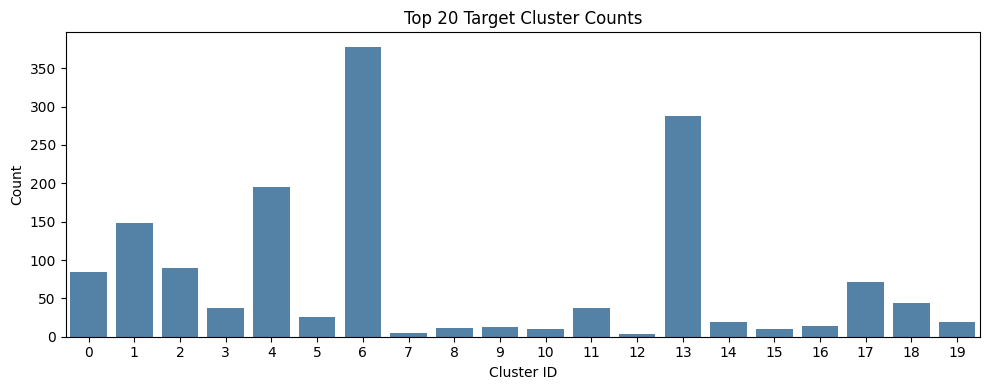

min_cap is 80, 
 max_cap is 104
Sampling targets: {np.int64(3): 101, np.int64(5): 80, np.int64(7): 104, np.int64(8): 95, np.int64(9): 80, np.int64(10): 104, np.int64(11): 100, np.int64(12): 102, np.int64(14): 80, np.int64(15): 80, np.int64(16): 80, np.int64(17): 104, np.int64(18): 91, np.int64(19): 104}
🔁 Applying SMOTE to balance classes...
✅ Resampled sequences: 2488 total samples
Post-SMOTE imbalance ratio: 3.04


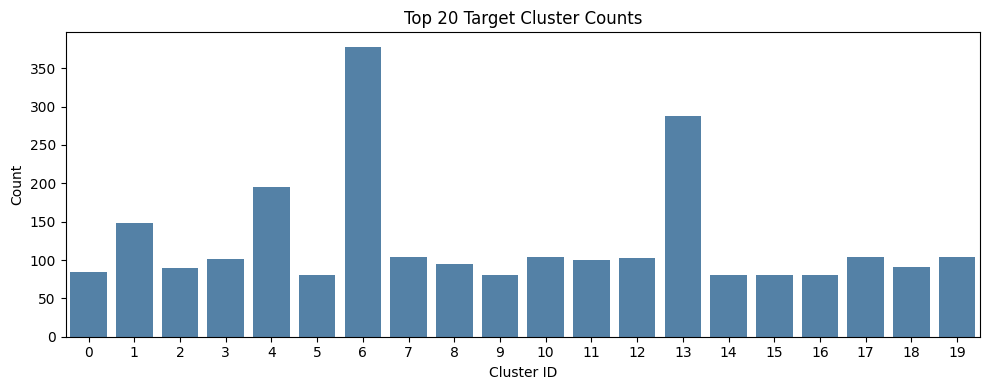

In [12]:

# Checking for Class Imbalance in sequence features
if y is None or len(y) == 0:
    print("No target sequences available.")
else:
    target_counts = pd.Series(y).value_counts().sort_values(ascending=False)
    imbalance_df = pd.DataFrame({
        "count": target_counts,
        "percent": target_counts / target_counts.sum() * 100,
        "cum_percent": target_counts.cumsum() / target_counts.sum() * 100,
    })
    display(imbalance_df)

    top_share = target_counts.iloc[0] / target_counts.sum()
    mean_share = 1 / len(target_counts)
    imbalance_ratio = top_share / mean_share
    is_imbalanced = imbalance_ratio > 1.5

    print(f"Unique target clusters: {target_counts.size}")
    print(f"Top cluster share: {top_share:.2%}")
    print(f"Mean expected share: {mean_share:.2%}")
    print(f"Imbalance ratio (top/mean): {imbalance_ratio:.2f}")
    print(f"Class imbalance detected: {is_imbalanced}")

    plt.figure(figsize=(10, 4))
    sns.barplot(x=target_counts.index[:20], y=target_counts.values[:20], color="steelblue")
    plt.title("Top 20 Target Cluster Counts")
    plt.xlabel("Cluster ID")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # To resolve Imbalance By Oversampling Minor Classes Using SMOTE
    if is_imbalanced:
        if not SMOTE_AVAILABLE:
            print("⚠️ SMOTE not available; skipping resampling.")
        else:

            unique_classes, counts = np.unique(y, return_counts=True)
            count_map = dict(zip(unique_classes, counts))

            # choose a baseline (median, P75, etc.)
            baseline = 80 #int(np.median(counts))

            # set how much wiggle room you want
            jitter_pct = 0.5            # +/- 10 %
            min_cap    = baseline        # ensure we at least hit the baseline
            max_cap    = int(baseline * 1.3)   # optional ceiling to avoid huge classes

            print(f"min_cap is {min_cap}, \n max_cap is {max_cap}")

            rng = np.random.default_rng(42)
            sampling_strategy = {}

            for cls in unique_classes:
                cls_count = count_map[cls]

                if cls_count < baseline:
                    jitter = rng.uniform(-jitter_pct, jitter_pct)
                    target = int(baseline * (1 + jitter))

                    # enforce ordering / bounds
                    target = max(target, cls_count)       # SMOTE cannot down-sample
                    target = max(target, min_cap)         # optional lower bound
                    target = min(target, max_cap)         # optional upper bound

                    sampling_strategy[cls] = target

            print("Sampling targets:", sampling_strategy)

            # choose k_neighbors carefully: it must be < min minority count
            minority_min = min(count_map[c] for c in sampling_strategy)
            k_neighbors = min(5, minority_min - 1) if minority_min > 1 else 1

            print("🔁 Applying SMOTE to balance classes...")
            X_flat = X.reshape(X.shape[0], -1)
            smote = SMOTE(
                sampling_strategy=sampling_strategy,
                k_neighbors=k_neighbors,
                random_state=42
                        )
            X_resampled, y_resampled = smote.fit_resample(X_flat, y)
            X = X_resampled.reshape(-1, X.shape[1], X.shape[2])
            y = y_resampled
            print(f"✅ Resampled sequences: {len(y)} total samples")

            target_counts = pd.Series(y).value_counts().sort_values(ascending=False)
            top_share = target_counts.iloc[0] / target_counts.sum()
            mean_share = 1 / len(target_counts)
            imbalance_ratio = top_share / mean_share
            print(f"Post-SMOTE imbalance ratio: {imbalance_ratio:.2f}")

    plt.figure(figsize=(10, 4))
    sns.barplot(x=target_counts.index[:20], y=target_counts.values[:20], color="steelblue")
    plt.title("Top 20 Target Cluster Counts")
    plt.xlabel("Cluster ID")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    # from imblearn.over_sampling import SMOTE